<a href="https://colab.research.google.com/github/Ovocode05/NeuroDeff/blob/main/LTNE_rel2_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from matplotlib import cm
import os

In [3]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf

In [3]:
class PINN(nn.Module):
    def __init__(self, layers, neurons, activation='tanh'):
        super(PINN, self).__init__()

        # Map from string to actual nn.Module activation
        activation_map = {
            "tanh": nn.Tanh(),
            "relu": nn.ReLU(),
            "sigmoid": nn.Sigmoid(),
            "swish":nn.SiLU(),  # Swish ≈ SiLU in PyTorch
            "gelu": nn.GELU(),
            "elu": nn.ELU(),
        }

        if activation.lower() not in activation_map:
            raise ValueError(f"Unsupported activation '{activation}'. Choose from: {list(activation_map.keys())}")

        act_fn = activation_map[activation.lower()]
        net_layers = [nn.Linear(1, neurons)]
        for _ in range(layers - 1):
            net_layers.append(nn.Linear(neurons, neurons))
            net_layers.append(act_fn)

        net_layers.append(nn.Linear(neurons, 2))  # Two outputs: T_f, T_s
        self.net = nn.Sequential(*net_layers)

    def forward(self, x):
        return self.net(x)

In [4]:
def gradients(T, x, order=1):
    if order == 1:
        grad = torch.autograd.grad(
            T, x,
            grad_outputs=torch.ones_like(T),
            create_graph=True,
            retain_graph=True,
            allow_unused=True  # Important for debugging
        )[0]
        if grad is None:
            raise RuntimeError("First derivative returned None. Check if x has requires_grad=True and is used.")
        return grad

    elif order == 2:
        T_x = gradients(T, x, order=1)
        if T_x is None:
            raise RuntimeError("First derivative for second-order grad is None.")
        grad2 = torch.autograd.grad(
            T_x, x,
            grad_outputs=torch.ones_like(T_x),
            create_graph=True,
            retain_graph=True,
            allow_unused=True,
            order=1
        )[0]
        if grad2 is None:
            raise RuntimeError("Second derivative returned None.")
        return grad2


In [5]:
def get_collocation_points(n_domain=300, n_bc=50):
    x_domain = torch.linspace(0, 1, n_domain).view(-1, 1)
    x_bc_left = torch.zeros(n_bc, 1)
    x_bc_right = torch.ones(n_bc, 1)

    x_domain.requires_grad_()
    x_bc_left.requires_grad_()
    x_bc_right.requires_grad_()

    return x_domain, x_bc_left, x_bc_right

In [6]:
def chebyshev_points(n):
    i = torch.arange(n).float()
    x = 0.5 * (1 - torch.cos((np.pi * i) / (n - 1)))  # Scaled to [0, 1]
    return x.view(-1, 1)

In [7]:
def residual_loss(x_domain:torch.Tensor, model, config:dict):
  # Ensure x_domain requires gradients for differentiation
  x_domain.requires_grad_()
  output = model(x_domain)
  T_f = output[:, 0:1]
  T_s = output[:, 1:2]

  T_f_n = gradients(T_f, x_domain, order=1)
  T_f_nn = gradients(T_f_n, x_domain, order=1) # Calculate second derivative from the first derivative
  T_s_n = gradients(T_s, x_domain, order=1)
  T_s_nn = gradients(T_s_n, x_domain, order=1) # Calculate second derivative from the first derivative

  # Dynamic parameter handling
  def get_param(name):
        val = config["physics"][name]
        if name in config["physics"]["varying_params"]:
            if callable(val):
                return val(x_domain)
            elif isinstance(val, (list, np.ndarray)):
                return val
        return val

  eps = get_param('eps')
  k = get_param('k')
  delta = get_param('delta')
  beta = get_param('beta')
  Bi = get_param('Bi')

  eqn1 = (eps * k * (1 + delta * T_f) * T_f_nn +
            eps * k * delta * (T_f_n**2) +
            Bi * (T_s - T_f) - 1 - beta)

  eqn2 = ((1 - eps) * (1 + delta * T_s) * T_s_nn +
            (1 - eps) * delta * (T_s_n**2) -
            Bi * (T_s - T_f) + beta)

  loss_eqn = torch.mean(eqn1**2) + torch.mean(eqn2**2)
  return loss_eqn

In [8]:
def boundary_loss(model, x_left, x_right):
    # Ensure boundary points require gradients
    x_left.requires_grad_(True)
    x_right.requires_grad_(True)

    out_left = model(x_left)
    out_right = model(x_right)

    T_f_right = out_right[:, 0:1]
    T_s_right = out_right[:, 1:2]

    T_f_n_left = gradients(out_left[:, 0:1], x_left)
    T_s_n_left = gradients(out_left[:, 1:2], x_left)

    loss_bc = (
        torch.mean((T_f_right - 0)**2) +
        torch.mean((T_s_right - 0)**2) +
        torch.mean((T_f_n_left - 0)**2) +
        torch.mean((T_s_n_left - 0)**2)
    )
    return loss_bc

In [9]:
def relation_dict(x:np.ndarray) -> dict:
  RELATIONS = {
      "relation_2_a" : {
            "network": { "neurons":264, "layers":3},  # Same as before
            "training": {"activation":"swish", "lr":0.001,
                         "lose_weights": [1,10],
                         "epochs":5000, "display_every":1000 },
            "physics": {
                "eps": 0.1,
                "k": 25,
                "delta": -0.2,
                "beta": 10,
                "Bi": [ lambda x: 50.0 * (1 - x),
                        lambda x: 50.0 * (1 + x),
                        lambda x: 50.0 * (1 - x**2),
                        lambda x: 50.0 * (1 + x**2)],
                "varying_params": ["Bi"]  # Specify which params vary
            },
      },
      "relation_2_b" : {
            "network": { "neurons":264, "layers":3},  # Same as before
            "training": {"activation":"swish", "lr":0.001,
                         "lose_weights": [1, 10],
                         "epochs":5000, "display_every":1000 },
            "physics": {
                "eps": 0.6,
                "k": 25,
                "delta": -0.2,
                "beta": 10,
                "Bi": [ lambda x: 50.0 * (1 - x),
                        lambda x: 50.0 * (1 + x),
                        lambda x: 50.0 * (1 - x**2),
                        lambda x: 50.0 * (1 + x**2)],
                "varying_params": ["Bi"]  # Specify which params vary
            },
      }
  }
  return RELATIONS

In [10]:
class EarlyStopping:
    def __init__(self, patience=1000, min_delta=1e-6):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.should_stop = False

    def __call__(self, current_loss):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True


In [11]:
def train_pinn(config:dict):
  model = PINN(config["network"]["layers"], config["network"]["neurons"], activation=config["training"]["activation"])
  adam = torch.optim.AdamW(model.parameters(), lr=config["training"]["lr"])
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(adam ,4000,1e-6, -1)
  w_pde, w_bc = config["training"]["lose_weights"]
  early_stopper = EarlyStopping(patience=2000, min_delta=1e-5)

  for epoch in range(config["training"]["epochs"]):
    adam.zero_grad()

    x_domain, x_bc_left, x_bc_right = get_collocation_points()
    loss_pde = residual_loss(x_domain, model, config)
    loss_bc = boundary_loss(model, x_bc_left, x_bc_right)

    loss = w_pde*loss_pde + w_bc*loss_bc
    loss.backward()
    adam.step()
    scheduler.step()

    if epoch % config["training"]["display_every"] == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.5e}  (PDE: {loss_pde.item():.2e}, BC: {loss_bc.item():.2e})")

    early_stopper(loss.item())
    if early_stopper.should_stop:
            print(f"Early stopping at epoch {epoch}")
            break

  print("Starting L-BFGS refinement...")
  lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=50)

  def closure():
        lbfgs.zero_grad()
        x_domain, x_bc_left, x_bc_right = get_collocation_points()
        loss_pde = residual_loss(x_domain, model, config)
        loss_bc = boundary_loss(model, x_bc_left, x_bc_right)
        loss = w_pde * loss_pde + w_bc * loss_bc
        loss.backward()
        return loss

  lbfgs.step(closure)

  print("L-BFGS refinement complete.")
  return model

In [12]:
def predict_temperatures(model, x_test)->dict:
  model.eval()
  with torch.no_grad():
    T_pred = model(x_test)
  return T_pred

In [13]:
def run_relation(relation_name: str, n: np.ndarray) -> dict:
    """Handles any relation from the config without deepcopy issues"""
    config = relation_dict(n)[relation_name]
    results_predict = {}
    # Prepare parameter combinations for other relations
    varying_params = config["physics"]["varying_params"]
    param_values = [
        config["physics"][p] if isinstance(config["physics"][p], (list, np.ndarray)) else [config["physics"][p]]
         for p in varying_params
      ]

    for combo in product(*param_values):
        param_str = "_".join(f"{p}={v}" for p,v in zip(varying_params, combo))
        print(f"\nTraining {relation_name} with {param_str}") #help to track which combo is being trained
        #we make a new config for every combo
        current_physics = config["physics"].copy()

        for p, v in zip(varying_params, combo):
             current_physics[p] = v
             current_config = {
                "network": config["network"],
                "training": config["training"],
                "physics": current_physics
              }
             model = train_pinn(current_config)
             T_pred = predict_temperatures(model, n)
             results_predict[param_str] = {
                "x": torch.flatten(n),
                "T_f": T_pred[:, 0:1],
                "T_s": T_pred[:, 1:2],
                "params": dict(zip(varying_params, combo))
                }

    return results_predict

In [14]:
def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [15]:
from collections import defaultdict
def plot_grouped_by_Bi(results, title_prefix="PINN Prediction Grouped by Bi", save_dir="Result01"):
    ensure_dir(save_dir)
    """
    For each unique Bi (from result key), plot all (Tf, Ts) curves for that Bi in one figure.
    """
    grouped = defaultdict(dict)
    for key, res in results.items():
        # Parse key like "Bi=<func>_delta=0.4"
        bi_key = [kv for kv in key.split('_') if kv.startswith("Bi=")][0]
        grouped[bi_key][key] = res

    # Step 2: Plot each Bi group in its own figure
    for bi_label, group in grouped.items():
        plt.figure(figsize=(10, 6))
        colors = plt.cm.tab10.colors

        for i, (label, res) in enumerate(group.items()):
            x = res["x"]
            T_f = res["T_f"].flatten()
            T_s = res["T_s"].flatten()
            color = colors[i % len(colors)]

            plt.plot(x, T_s, color=color, linestyle='-')
            plt.plot(x, T_f, color=color, linestyle='--')

        plt.xlabel("x")
        plt.ylabel("Temperature")
        plt.title(f"{title_prefix}: {bi_label}")
        plt.legend(fontsize="small")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        #save
        fig_path = os.path.join(save_dir, f"01_{bi_label}.png")
        plt.savefig(fig_path)
        plt.close()



Training relation_2_a with Bi=<function relation_dict.<locals>.<lambda> at 0x7b89b7ffbb00>
Epoch 0: Loss = 1.75371e+02  (PDE: 1.75e+02, BC: 6.80e-03)
Epoch 1000: Loss = 5.74611e-03  (PDE: 5.44e-03, BC: 3.01e-05)
Epoch 2000: Loss = 1.35176e-03  (PDE: 1.32e-03, BC: 3.41e-06)
Epoch 3000: Loss = 1.21096e-03  (PDE: 1.20e-03, BC: 1.31e-06)
Epoch 4000: Loss = 1.14155e-03  (PDE: 1.13e-03, BC: 9.47e-07)
Epoch 5000: Loss = 9.01162e-04  (PDE: 8.97e-04, BC: 4.17e-07)
Epoch 6000: Loss = 1.26982e-03  (PDE: 1.27e-03, BC: 3.46e-07)
Epoch 7000: Loss = 2.93433e-04  (PDE: 2.93e-04, BC: 2.75e-08)
Epoch 8000: Loss = 1.57917e-03  (PDE: 1.57e-03, BC: 7.57e-07)
Epoch 9000: Loss = 2.54075e-01  (PDE: 2.30e-01, BC: 2.41e-03)
Starting L-BFGS refinement...
L-BFGS refinement complete.

Training relation_2_a with Bi=<function relation_dict.<locals>.<lambda> at 0x7b89b7ffb100>
Epoch 0: Loss = 1.85613e+01  (PDE: 1.84e+01, BC: 1.14e-02)
Epoch 1000: Loss = 1.78748e-01  (PDE: 8.72e-02, BC: 9.16e-03)
Epoch 2000: Loss = 8

/tmp/ipython-input-15-388220541.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="small")


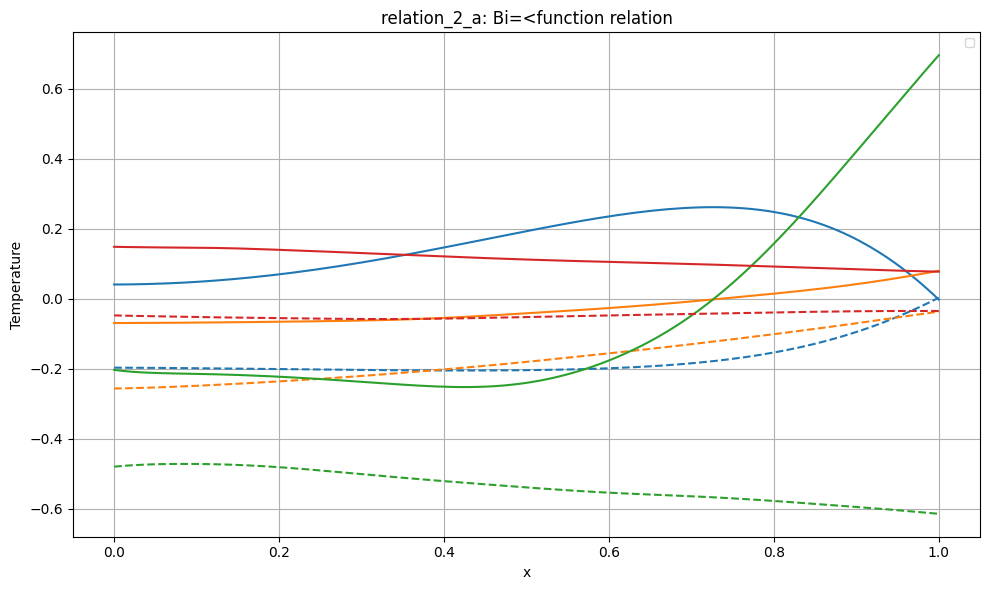


Training relation_2_b with Bi=<function relation_dict.<locals>.<lambda> at 0x7b89a2434540>
Epoch 0: Loss = 2.16050e+02  (PDE: 2.16e+02, BC: 2.25e-02)
Epoch 1000: Loss = 7.39350e-02  (PDE: 6.98e-02, BC: 4.16e-04)
Epoch 2000: Loss = 1.53792e-02  (PDE: 1.25e-02, BC: 2.90e-04)
Epoch 3000: Loss = 1.17161e-02  (PDE: 9.89e-03, BC: 1.83e-04)
Epoch 4000: Loss = 1.07945e-02  (PDE: 9.22e-03, BC: 1.57e-04)
Epoch 5000: Loss = 2.12509e-01  (PDE: 2.10e-01, BC: 2.80e-04)
Epoch 6000: Loss = 6.56870e-03  (PDE: 5.94e-03, BC: 6.33e-05)
Epoch 7000: Loss = 2.18240e+01  (PDE: 2.11e+01, BC: 7.02e-02)
Epoch 8000: Loss = 2.50880e-01  (PDE: 1.54e-01, BC: 9.72e-03)
Early stopping at epoch 8789
Starting L-BFGS refinement...
L-BFGS refinement complete.

Training relation_2_b with Bi=<function relation_dict.<locals>.<lambda> at 0x7b89a24356c0>
Epoch 0: Loss = 2.60157e+02  (PDE: 2.60e+02, BC: 3.83e-03)
Epoch 1000: Loss = 1.32175e-01  (PDE: 4.08e-02, BC: 9.14e-03)
Epoch 2000: Loss = 1.25217e-01  (PDE: 3.32e-02, BC: 9

/tmp/ipython-input-15-388220541.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="small")


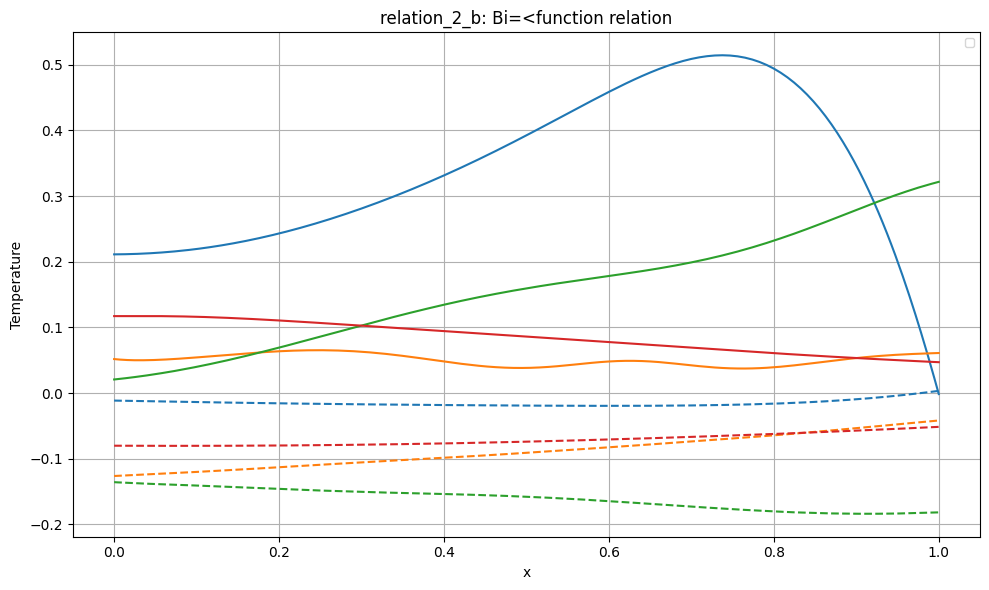

In [16]:
n= torch.linspace(0, 1, 150).view(-1, 1)
# test_points = chebyshev_points(n)
all_results = {}

for relation in ["relation_2_a", "relation_2_b"]:
    all_results[relation] = run_relation(relation, test_points)
    plot_grouped_by_Bi(all_results[relation], title_prefix=relation)